In [11]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np

"""
Implement representation of hypercube:
- First four Qubits represent position within hypercube (four qubits to represent each of the 16 vertices) 
- Last two qubits represent coin
"""
one_step_circuit = QuantumCircuit(6, name=' ONE STEP')

# Implement Grover Coin (coin operator), which is diffuser in Grover's Algorithm
one_step_circuit.h([4,5])
one_step_circuit.z([4,5])
one_step_circuit.cz(4,5)
one_step_circuit.h([4,5])
one_step_circuit.draw()

q_0: ──────────────────
                       
q_1: ──────────────────
                       
q_2: ──────────────────
                       
q_3: ──────────────────
     ┌───┐┌───┐   ┌───┐
q_4: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_5: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

In [12]:
# Shift operator function for 4d-hypercube; walker can only move to neighboring nodes, which differ by only one bit
def shift_operator(circuit):
    
    for i in range(0,4):
        # apply not gate to 1st coin qubit
        circuit.x(4)

         # apply not gate every other time to 2nd coin qubit
        if i%2==0:
            circuit.x(5)

        # makes it so that the position of the walker is dependent on the coin value (quantum entanglement)
        circuit.ccx(4,5,i)

"""
- Coin is |11> means to move walker to state where the first node qubit differs
- Coin is |10> or |01> means to move walker to state where the second and third qubit, respectively, differ
- Coin is |00> means to move walker to state where the fourth node qubit differs
"""
shift_operator(one_step_circuit)

# take one step of the quantum walk
one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw()

┌───┐                              
q_0: ───────────────────────┤ X ├──────────────────────────────
                            └─┬─┘     ┌───┐                    
q_1: ─────────────────────────┼───────┤ X ├────────────────────
                              │       └─┬─┘     ┌───┐          
q_2: ─────────────────────────┼─────────┼───────┤ X ├──────────
                              │         │       └─┬─┘     ┌───┐
q_3: ─────────────────────────┼─────────┼─────────┼───────┤ X ├
     ┌───┐┌───┐   ┌───┐┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐└─┬─┘
q_4: ┤ H ├┤ Z ├─■─┤ H ├┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──
     ├───┤├───┤ │ ├───┤├───┤  │  └───┘  │  ├───┤  │  └───┘  │  
q_5: ┤ H ├┤ Z ├─■─┤ H ├┤ X ├──■─────────■──┤ X ├──■─────────■──
     └───┘└───┘   └───┘└───┘               └───┘

In [13]:
# Generate the inverse of the circuit above
one_step_circuit.inverse().draw() 

┌───┐                       
q_0: ──────────────────────────────┤ X ├───────────────────────
                         ┌───┐     └─┬─┘                       
q_1: ────────────────────┤ X ├───────┼─────────────────────────
               ┌───┐     └─┬─┘       │                         
q_2: ──────────┤ X ├───────┼─────────┼─────────────────────────
     ┌───┐     └─┬─┘       │         │                         
q_3: ┤ X ├───────┼─────────┼─────────┼─────────────────────────
     └─┬─┘┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐┌───┐   ┌───┐┌───┐
q_4: ──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├┤ H ├─■─┤ Z ├┤ H ├
       │  └───┘  │  ├───┤  │  └───┘  │  ├───┤├───┤ │ ├───┤├───┤
q_5: ──■─────────■──┤ X ├──■─────────■──┤ X ├┤ H ├─■─┤ Z ├┤ H ├
                    └───┘               └───┘└───┘   └───┘└───┘

In [14]:
# Make controlled gates that act on 2 or more qubits
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

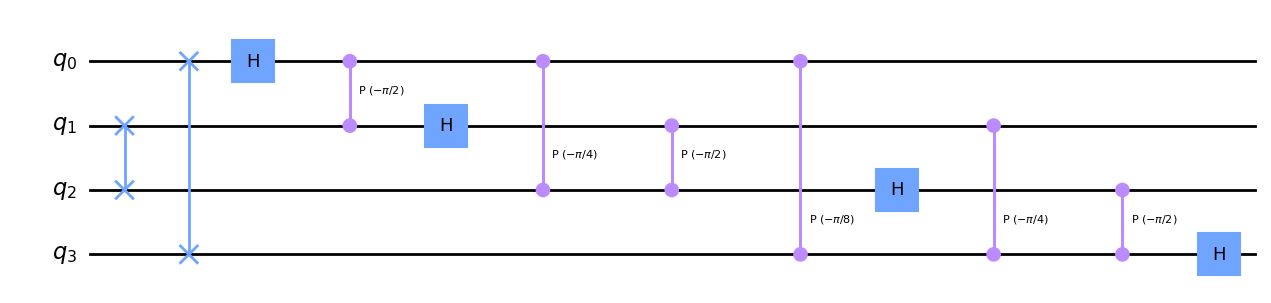

In [15]:
# Implement quantum fourier transform (QFT) and inverse QFT
inv_qft_gate = QFT(4, inverse=True).to_instruction()  
qft_gate = QFT(4, inverse=False).to_instruction()

# First two "lines" in circuit are SWAP gates --> swap 2 qubits
QFT(4, inverse=True).decompose().draw("mpl")

In [16]:
"""
Implement the phase oracle that marks two vertices in the graph
"""

phase_circuit =  QuantumCircuit(6, name=' phase oracle ')

# Mark 1011
phase_circuit.x(2)
phase_circuit.h(3)
phase_circuit.mct([0,1,2], 3)
phase_circuit.h(3)
phase_circuit.x(2)

# Mark 1111
phase_circuit.h(3)
phase_circuit.mct([0,1,2],3)
phase_circuit.h(3)
phase_oracle_gate = phase_circuit.to_instruction()

# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(11, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
phase_circuit.draw()

q_0: ───────■──────────────■───────
            │              │       
q_1: ───────■──────────────■───────
     ┌───┐  │  ┌───┐       │       
q_2: ┤ X ├──■──┤ X ├───────■───────
     ├───┤┌─┴─┐├───┤┌───┐┌─┴─┐┌───┐
q_3: ┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘
q_4: ──────────────────────────────
                                   
q_5: ──────────────────────────────

In [17]:
"""
Implement gate that rotates an auxiliary qubit if the other qubits are non-zero
"""

# Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(5, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3,4])
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.z(4)
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.x([0,1,2,3,4])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw()

┌───┐               ┌───┐
q_0: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_1: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_2: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_3: ┤ X ├──■─────────■──┤ X ├
     ├───┤┌─┴─┐┌───┐┌─┴─┐├───┤
q_4: ┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘

In [18]:
"""
- Implement phase estimation one step of the quantum walk followed by an auxiliary qubit that we rotate if θ ≠ 0
- Then reverse the phase estimation
"""

# Phase estimation
phase_estimation_circuit = QuantumCircuit(11, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i,4,5,6,7,8,9])

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,3,10])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])   

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i,4,5,6,7,8,9])
phase_estimation_circuit.barrier(range(0,10))
phase_estimation_circuit.h([0,1,2,3])

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw()

┌───┐┌──────────────┐                                                »
 q_0: ┤ H ├┤0             ├────────────────────────────────────────────────»
      ├───┤│              │┌──────────────┐┌──────────────┐                »
 q_1: ┤ H ├┤              ├┤0             ├┤0             ├────────────────»
      ├───┤│              ││              ││              │┌──────────────┐»
 q_2: ┤ H ├┤              ├┤              ├┤              ├┤0             ├»
      ├───┤│              ││              ││              ││              │»
 q_3: ┤ H ├┤              ├┤              ├┤              ├┤              ├»
      └───┘│              ││              ││              ││              │»
 q_4: ─────┤1             ├┤1             ├┤1             ├┤1             ├»
           │  c_ ONE STEP ││              ││              ││              │»
 q_5: ─────┤2             ├┤2 c_ ONE STEP ├┤2 c_ ONE STEP ├┤2             ├»
           │              ││              ││              ││  c_ ONE STEP │»
 q_6: ─────┤3             ├┤3             ├┤3             ├┤3             ├»
           │              ││              ││              ││              │»
 q_7: ─────┤4             ├┤4             ├┤4             ├┤4             ├»
           │              ││              ││              ││              │»
 q_8: ─────┤5             ├┤5             ├┤5             ├┤5             ├»
           │              ││              ││              ││              │»
 q_9: ─────┤6             ├┤6             ├┤6             ├┤6             ├»
           └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
q_10: ─────────────────────────────────────────────────────────────────────»
                                                                           »
«                                                                      »
« q_0: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_1: ────────────────────────────────────────────────────────────────»
«      ┌──────────────┐┌──────────────┐┌──────────────┐                »
« q_2: ┤0             ├┤0             ├┤0             ├────────────────»
«      │              ││              ││              │┌──────────────┐»
« q_3: ┤              ├┤              ├┤              ├┤0             ├»
«      │              ││              ││              ││              │»
« q_4: ┤1             ├┤1             ├┤1             ├┤1             ├»
«      │              ││              ││              ││              │»
« q_5: ┤2             ├┤2             ├┤2             ├┤2             ├»
«      │  c_ ONE STEP ││  c_ ONE STEP ││  c_ ONE STEP ││              │»
« q_6: ┤3             ├┤3             ├┤3             ├┤3 c_ ONE STEP ├»
«      │              ││              ││              ││              │»
« q_7: ┤4             ├┤4             ├┤4             ├┤4             ├»
«      │              ││              ││              ││              │»
« q_8: ┤5             ├┤5             ├┤5             ├┤5             ├»
«      │              ││              ││              ││              │»
« q_9: ┤6             ├┤6             ├┤6             ├┤6             ├»
«      └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«q_10: ────────────────────────────────────────────────────────────────»
«                                                                      »
«                                                                      »
« q_0: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_1: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_2: ────────────────────────────────────────────────────────────────»
«      ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
« q_3: ┤0             ├┤0             ├┤0    

In [19]:
"""
Implementation of the full quantum walk search algorithm:
1. Applying Hadamard gates to node and coin qubits
2. Apply phase oracle and phase estimation gates
3. Measure the node qubits
"""

theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(4, 'node') 
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')

# 4 classical bits to measure the node qubits at the end
creg_c2 = ClassicalRegister(4, 'c') 

circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)

# Apply Hadamard gates to the qubits that represent the nodes & the coin
circuit.h([4,5,6,7,8,9])

# QWS makes it possible to find marked set of nodes in O(1/sqrt(ε)) iterations
iterations = 2

# Add the phase oracle and phase estimation gates
for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9,10])

circuit.measure(node_q[0], creg_c2[0])
circuit.measure(node_q[1], creg_c2[1])
circuit.measure(node_q[2], creg_c2[2])
circuit.measure(node_q[3], creg_c2[3])
circuit.draw()

┌──────────────────────┐                   »
  theta_0: ────────────────────────┤0                     ├───────────────────»
                                   │                      │                   »
  theta_1: ────────────────────────┤1                     ├───────────────────»
                                   │                      │                   »
  theta_2: ────────────────────────┤2                     ├───────────────────»
                                   │                      │                   »
  theta_3: ────────────────────────┤3                     ├───────────────────»
           ┌───┐┌─────────────────┐│                      │┌─────────────────┐»
   node_0: ┤ H ├┤0                ├┤4                     ├┤0                ├»
           ├───┤│                 ││                      ││                 │»
   node_1: ┤ H ├┤1                ├┤5   phase estimation  ├┤1                ├»
           ├───┤│                 ││                      ││                 │»
   node_2: ┤ H ├┤2                ├┤6                     ├┤2                ├»
           ├───┤│   phase oracle  ││                      ││   phase oracle  │»
   node_3: ┤ H ├┤3                ├┤7                     ├┤3                ├»
           ├───┤│                 ││                      ││                 │»
   coin_0: ┤ H ├┤4                ├┤8                     ├┤4                ├»
           ├───┤│                 ││                      ││                 │»
   coin_1: ┤ H ├┤5                ├┤9                     ├┤5                ├»
           └───┘└─────────────────┘│                      │└─────────────────┘»
auxiliary: ────────────────────────┤10                    ├───────────────────»
                                   └──────────────────────┘                   »
      c: 4/═══════════════════════════════════════════════════════════════════»
                                                                              »
«           ┌──────────────────────┐            
«  theta_0: ┤0                     ├────────────
«           │                      │            
«  theta_1: ┤1                     ├────────────
«           │                      │            
«  theta_2: ┤2                     ├────────────
«           │                      │            
«  theta_3: ┤3                     ├────────────
«           │                      │┌─┐         
«   node_0: ┤4                     ├┤M├─────────
«           │                      │└╥┘┌─┐      
«   node_1: ┤5   phase estimation  ├─╫─┤M├──────
«           │                      │ ║ └╥┘┌─┐   
«   node_2: ┤6                     ├─╫──╫─┤M├───
«           │                      │ ║  ║ └╥┘┌─┐
«   node_3: ┤7                     ├─╫──╫──╫─┤M├
«           │                      │ ║  ║  ║ └╥┘
«   coin_0: ┤8                     ├─╫──╫──╫──╫─
«           │                      │ ║  ║  ║  ║ 
«   coin_1: ┤9                     ├─╫──╫──╫──╫─
«           │                      │ ║  ║  ║  ║ 
«auxiliary: ┤10                    ├─╫──╫──╫──╫─
«           └──────────────────────┘ ║  ║  ║  ║ 
«      c: 4/═════════════════════════╩══╩══╩══╩═
«                                    0  1  2  3

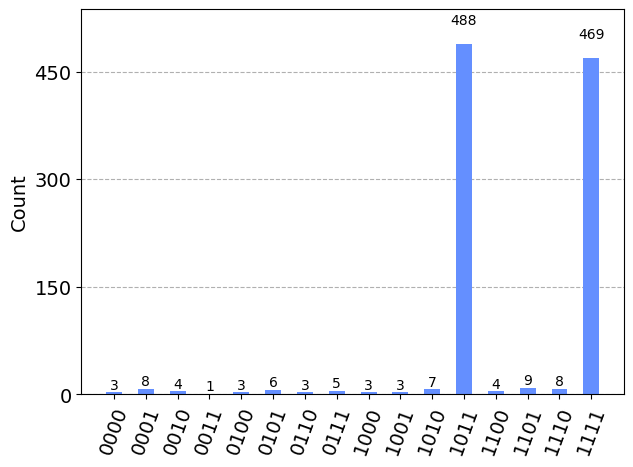

In [20]:
# Run implementation on qasm simulator to see results of circuit collapse
backend = Aer.get_backend('qasm_simulator') 
job = execute( circuit, backend, shots=1024 ) 
hist = job.result().get_counts() 
plot_histogram( hist )